In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 31 09:28:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.106.00   Driver Version: 460.106.00   CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A30                 On   | 00000000:03:00.0 Off |                    0 |
| N/A   31C    P0    28W / 165W |      0MiB / 24258MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.6322149629995693
GPU (s):
0.031081868990440853
GPU speedup over CPU: 20x


In [3]:
import os
import glob
import pandas as pd
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
def train_model(img_dir, preprocess):

  data_dir = pathlib.Path(img_dir)

  batch_size = 64
  img_height = 128
  img_width = 128

  IMG_SHAPE = (img_height, img_width) + (3,)

  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

  class_names = train_ds.class_names

  AUTOTUNE = tf.data.AUTOTUNE
  num_classes = len(class_names)

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

  # Create the base model from the pre-trained model
  base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
  
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(128, 128, 3))
  x = data_augmentation(inputs)

  if preprocess == True:
    x = tf.keras.applications.densenet.preprocess_input(x)
    print("Using preprocessing")

  x = base_model(x)
  x = tf.keras.layers.MaxPooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  outputs = tf.keras.layers.Dense(5)(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0005

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  epochs=100
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()
    
  return {'acc': acc, 'val_acc': val_acc, 'loss': loss, 'val_loss': val_loss}

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
29097984/29084464 [==============================] - 23s 1us/step
Using preprocessing
Epoch 1/100
360/360 [==============================] - 26s 48ms/step - loss: 0.9037 - accuracy: 0.6352 - val_loss: 0.7540 - val_accuracy: 0.6836
Epoch 2/100
360/360 [==============================] - 15s 41ms/step - loss: 0.7321 - accuracy: 0.6883 - val_loss: 0.6950 - val_accuracy: 0.6926
Epoch 3/100
360/360 [==============================] - 14s 40ms/step - loss: 0.6970 - accuracy: 0.6987 - val_loss: 0.6961 - val_accuracy: 0.7077
Epoch 4/100
360/360 [==============================] - 14s 40ms/step - loss: 0.6779 - accuracy: 0.7104 - val_loss: 0.6459 - val_accuracy: 0.7261
Epoch 5/100
360/360 [==============================] - 14s 40ms/step - loss: 0.6697 - accuracy: 0.7139 - val_loss: 0.6538 - val_accuracy: 0.7174
Epoch 6/100
360/360 [===================

360/360 [==============================] - 13s 37ms/step - loss: 0.5446 - accuracy: 0.7720 - val_loss: 0.5807 - val_accuracy: 0.7560
Epoch 55/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5497 - accuracy: 0.7722 - val_loss: 0.5744 - val_accuracy: 0.7614
Epoch 56/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5424 - accuracy: 0.7750 - val_loss: 0.5701 - val_accuracy: 0.7595
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5392 - accuracy: 0.7750 - val_loss: 0.5665 - val_accuracy: 0.7640
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5467 - accuracy: 0.7737 - val_loss: 0.5720 - val_accuracy: 0.7607
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5389 - accuracy: 0.7751 - val_loss: 0.5931 - val_accuracy: 0.7516
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5510 - accuracy: 0.7718 - val_loss: 0.5736 - val_accuracy

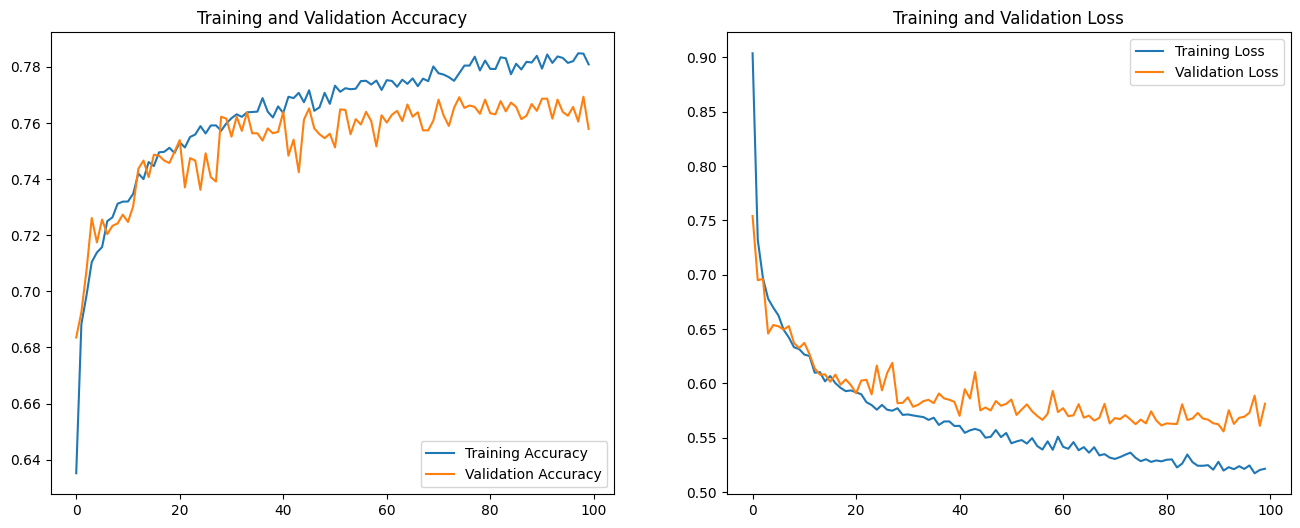

In [5]:
res_hls_pre = train_model('content/img_HLS', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 21s 41ms/step - loss: 2.8742 - accuracy: 0.3855 - val_loss: 1.1759 - val_accuracy: 0.5035
Epoch 2/100
360/360 [==============================] - 14s 38ms/step - loss: 1.2297 - accuracy: 0.4622 - val_loss: 1.1306 - val_accuracy: 0.5170
Epoch 3/100
360/360 [==============================] - 14s 38ms/step - loss: 1.1282 - accuracy: 0.5053 - val_loss: 1.0150 - val_accuracy: 0.5427
Epoch 4/100
360/360 [==============================] - 13s 36ms/step - loss: 1.0946 - accuracy: 0.5250 - val_loss: 1.0675 - val_accuracy: 0.5413
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 1.0576 - accuracy: 0.5357 - val_loss: 1.0343 - val_accuracy: 0.5533
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 1.0313 - accuracy: 0.5538 - val_loss: 0.9698 - va

360/360 [==============================] - 13s 36ms/step - loss: 0.8681 - accuracy: 0.6335 - val_loss: 0.8616 - val_accuracy: 0.6393
Epoch 57/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8709 - accuracy: 0.6310 - val_loss: 0.8434 - val_accuracy: 0.6532
Epoch 58/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8769 - accuracy: 0.6288 - val_loss: 0.8299 - val_accuracy: 0.6428
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8665 - accuracy: 0.6352 - val_loss: 0.8296 - val_accuracy: 0.6497
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8581 - accuracy: 0.6383 - val_loss: 0.8254 - val_accuracy: 0.6587
Epoch 61/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8573 - accuracy: 0.6390 - val_loss: 0.8122 - val_accuracy: 0.6586
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8659 - accuracy: 0.6328 - val_loss: 0.8274 - val_accuracy

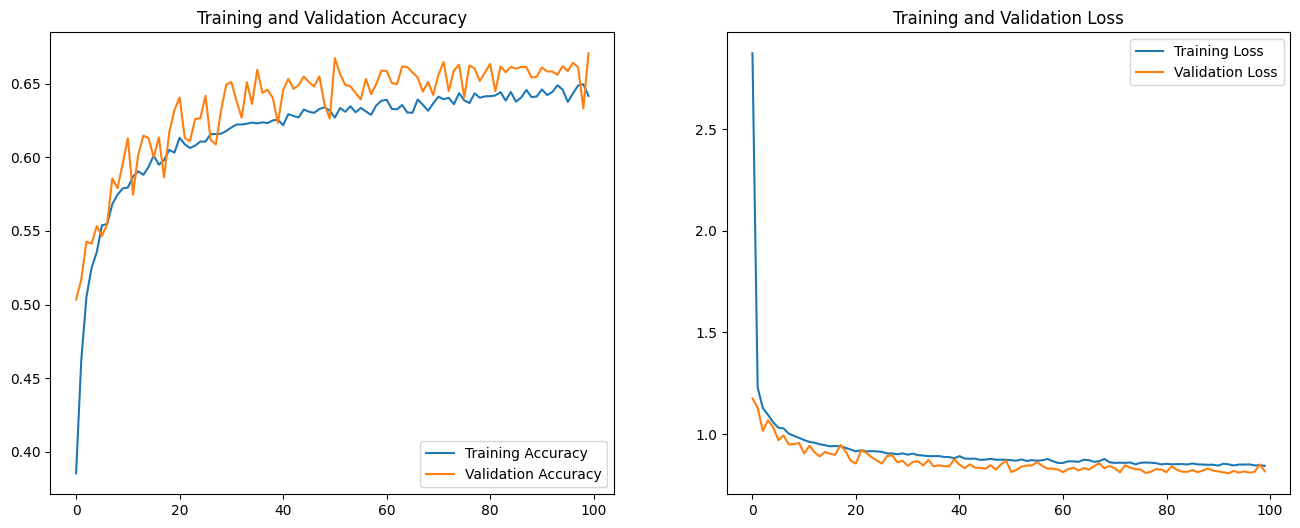

In [6]:
res_hls_nonpre = train_model('content/img_HLS', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 21s 41ms/step - loss: 0.6688 - accuracy: 0.7168 - val_loss: 0.5168 - val_accuracy: 0.7815
Epoch 2/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5575 - accuracy: 0.7638 - val_loss: 0.5174 - val_accuracy: 0.7860
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 0.5310 - accuracy: 0.7732 - val_loss: 0.4816 - val_accuracy: 0.8027
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5129 - accuracy: 0.7842 - val_loss: 0.5415 - val_accuracy: 0.7694
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5060 - accuracy: 0.7869 - val_loss: 0.4534 - val_accuracy: 0.8116
Epoch 6/100
360/360 [==============================] - 14s 38ms/step - loss: 0.4962 - accuracy: 0.7910 - v

360/360 [==============================] - 13s 37ms/step - loss: 0.3845 - accuracy: 0.8450 - val_loss: 0.3752 - val_accuracy: 0.8510
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3835 - accuracy: 0.8421 - val_loss: 0.3736 - val_accuracy: 0.8538
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3819 - accuracy: 0.8452 - val_loss: 0.3763 - val_accuracy: 0.8520
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3812 - accuracy: 0.8466 - val_loss: 0.3794 - val_accuracy: 0.8498
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3812 - accuracy: 0.8451 - val_loss: 0.3856 - val_accuracy: 0.8475
Epoch 61/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3759 - accuracy: 0.8470 - val_loss: 0.3817 - val_accuracy: 0.8486
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 0.3786 - accuracy: 0.8452 - val_loss: 0.3693 - val_accuracy

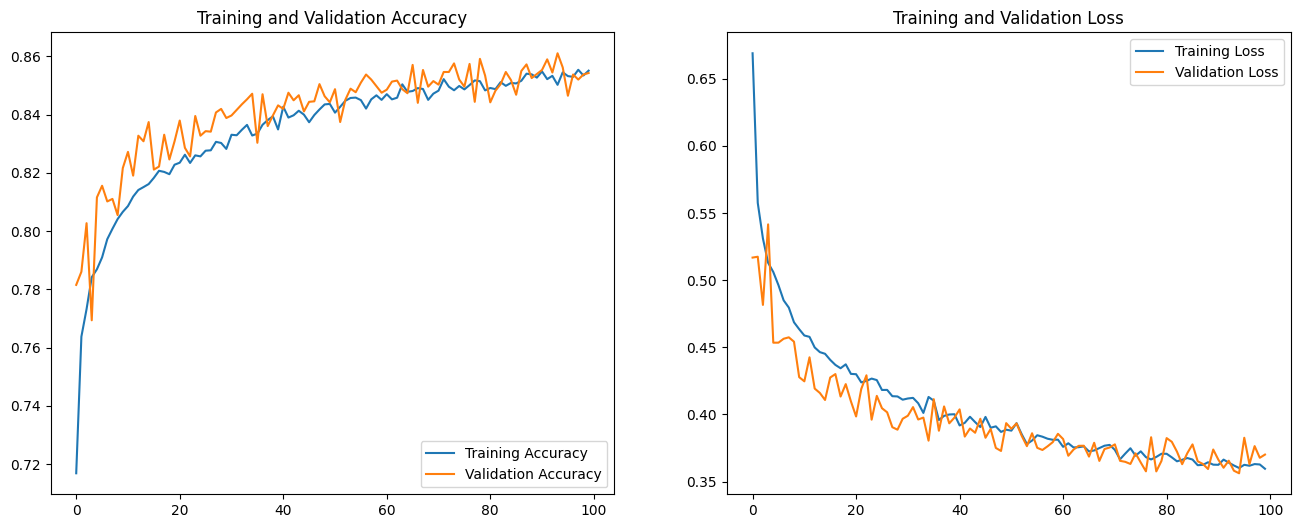

In [7]:
res_luv_pre = train_model('content/img_Luv', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 21s 40ms/step - loss: 2.0301 - accuracy: 0.4137 - val_loss: 1.0282 - val_accuracy: 0.5618
Epoch 2/100
360/360 [==============================] - 13s 36ms/step - loss: 1.0747 - accuracy: 0.5351 - val_loss: 0.8823 - val_accuracy: 0.6280
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 0.9699 - accuracy: 0.5834 - val_loss: 0.8724 - val_accuracy: 0.6289
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.9225 - accuracy: 0.6043 - val_loss: 0.8723 - val_accuracy: 0.6256
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8906 - accuracy: 0.6226 - val_loss: 0.8148 - val_accuracy: 0.6532
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.8699 - accuracy: 0.6310 - val_loss: 0.8566 - va

360/360 [==============================] - 13s 36ms/step - loss: 0.6636 - accuracy: 0.7347 - val_loss: 0.6171 - val_accuracy: 0.7661
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 0.6599 - accuracy: 0.7356 - val_loss: 0.6083 - val_accuracy: 0.7730
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 0.6684 - accuracy: 0.7332 - val_loss: 0.6195 - val_accuracy: 0.7767
Epoch 59/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6762 - accuracy: 0.7263 - val_loss: 0.6306 - val_accuracy: 0.7581
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 0.6658 - accuracy: 0.7308 - val_loss: 0.5988 - val_accuracy: 0.7708
Epoch 61/100
360/360 [==============================] - 13s 36ms/step - loss: 0.6727 - accuracy: 0.7309 - val_loss: 0.6309 - val_accuracy: 0.7480
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 0.6719 - accuracy: 0.7308 - val_loss: 0.6378 - val_accuracy

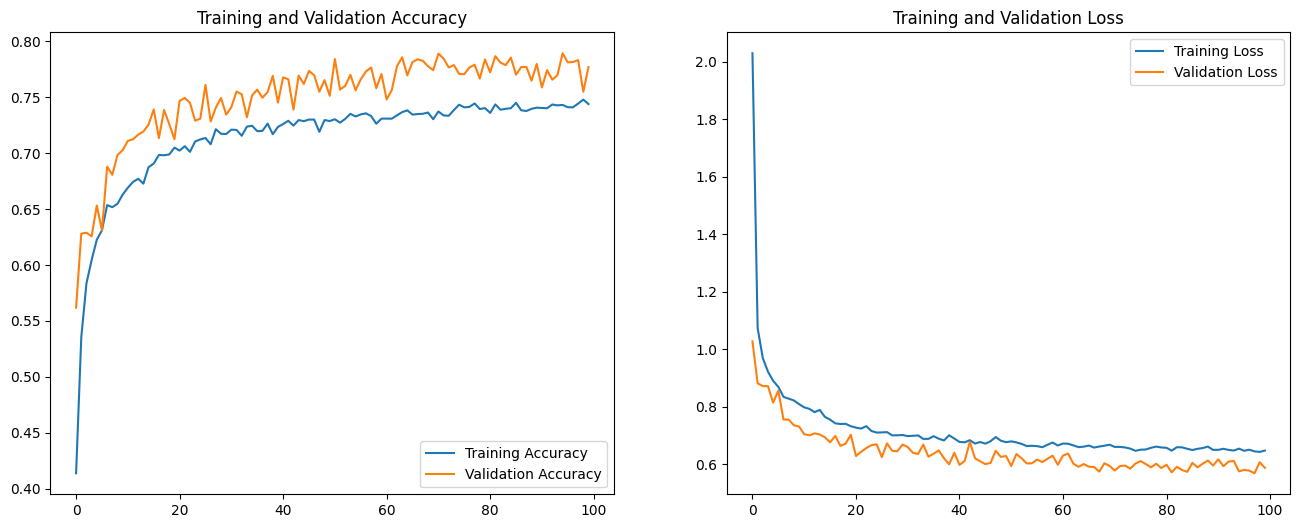

In [8]:
res_luv_nonpre = train_model('content/img_Luv', preprocess=False)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Using preprocessing
Epoch 1/100
360/360 [==============================] - 21s 41ms/step - loss: 0.7343 - accuracy: 0.6900 - val_loss: 0.5562 - val_accuracy: 0.7589
Epoch 2/100
360/360 [==============================] - 13s 37ms/step - loss: 0.6053 - accuracy: 0.7352 - val_loss: 0.5342 - val_accuracy: 0.7701
Epoch 3/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5841 - accuracy: 0.7495 - val_loss: 0.5272 - val_accuracy: 0.7768
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5596 - accuracy: 0.7592 - val_loss: 0.5134 - val_accuracy: 0.7798
Epoch 5/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5565 - accuracy: 0.7595 - val_loss: 0.5335 - val_accuracy: 0.7664
Epoch 6/100
360/360 [==============================] - 13s 37ms/step - loss: 0.5488 - accuracy: 0.7646 - v

360/360 [==============================] - 13s 36ms/step - loss: 0.4506 - accuracy: 0.8112 - val_loss: 0.4486 - val_accuracy: 0.8234
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4528 - accuracy: 0.8120 - val_loss: 0.4623 - val_accuracy: 0.8164
Epoch 58/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4459 - accuracy: 0.8141 - val_loss: 0.4540 - val_accuracy: 0.8154
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4452 - accuracy: 0.8125 - val_loss: 0.4506 - val_accuracy: 0.8163
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4383 - accuracy: 0.8191 - val_loss: 0.4308 - val_accuracy: 0.8270
Epoch 61/100
360/360 [==============================] - 13s 37ms/step - loss: 0.4443 - accuracy: 0.8156 - val_loss: 0.4359 - val_accuracy: 0.8227
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 0.4383 - accuracy: 0.8170 - val_loss: 0.4392 - val_accuracy

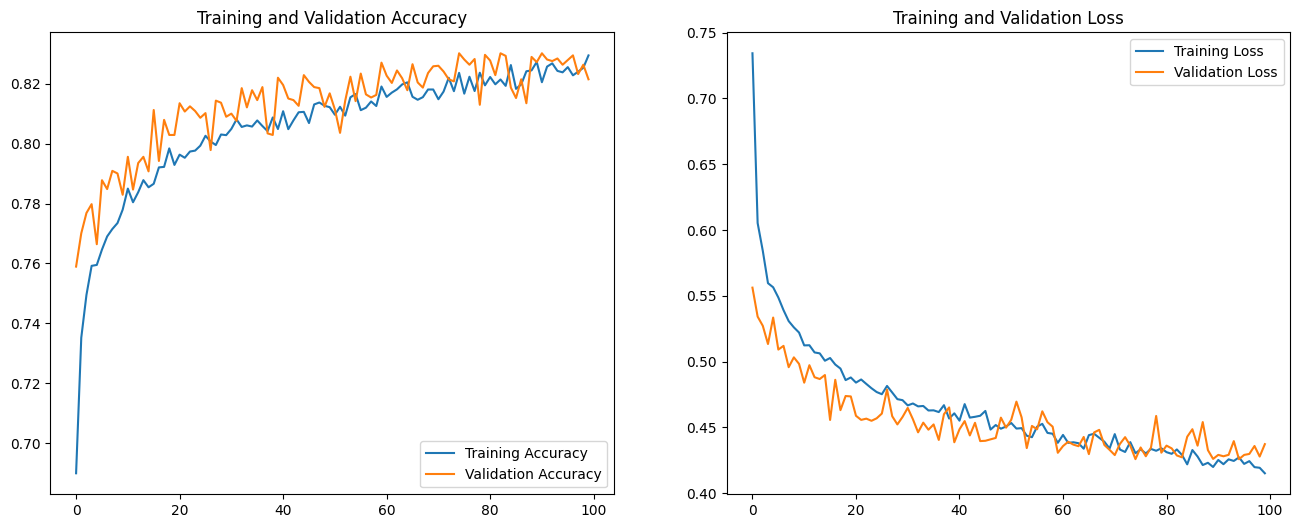

In [9]:
res_ycrcb_pre = train_model('content/img_YCrCb', preprocess=True)

Found 28793 files belonging to 5 classes.
Using 23035 files for training.
Found 28793 files belonging to 5 classes.
Using 5758 files for validation.
Epoch 1/100
360/360 [==============================] - 21s 40ms/step - loss: 2.7663 - accuracy: 0.3983 - val_loss: 1.2547 - val_accuracy: 0.4276
Epoch 2/100
360/360 [==============================] - 13s 36ms/step - loss: 1.1717 - accuracy: 0.4941 - val_loss: 1.0317 - val_accuracy: 0.5613
Epoch 3/100
360/360 [==============================] - 13s 36ms/step - loss: 1.0623 - accuracy: 0.5444 - val_loss: 0.9307 - val_accuracy: 0.6042
Epoch 4/100
360/360 [==============================] - 13s 37ms/step - loss: 1.0107 - accuracy: 0.5717 - val_loss: 0.8782 - val_accuracy: 0.6289
Epoch 5/100
360/360 [==============================] - 13s 36ms/step - loss: 0.9683 - accuracy: 0.5835 - val_loss: 0.8368 - val_accuracy: 0.6530
Epoch 6/100
360/360 [==============================] - 13s 36ms/step - loss: 0.9474 - accuracy: 0.5930 - val_loss: 0.8767 - va

360/360 [==============================] - 13s 36ms/step - loss: 0.8100 - accuracy: 0.6567 - val_loss: 0.7564 - val_accuracy: 0.6957
Epoch 57/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8136 - accuracy: 0.6552 - val_loss: 0.7309 - val_accuracy: 0.6966
Epoch 58/100
360/360 [==============================] - 13s 35ms/step - loss: 0.8093 - accuracy: 0.6574 - val_loss: 0.7317 - val_accuracy: 0.7240
Epoch 59/100
360/360 [==============================] - 13s 36ms/step - loss: 0.7979 - accuracy: 0.6625 - val_loss: 0.7589 - val_accuracy: 0.6881
Epoch 60/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8049 - accuracy: 0.6629 - val_loss: 0.7757 - val_accuracy: 0.6969
Epoch 61/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8063 - accuracy: 0.6623 - val_loss: 0.7216 - val_accuracy: 0.7126
Epoch 62/100
360/360 [==============================] - 13s 36ms/step - loss: 0.8048 - accuracy: 0.6635 - val_loss: 0.7379 - val_accuracy

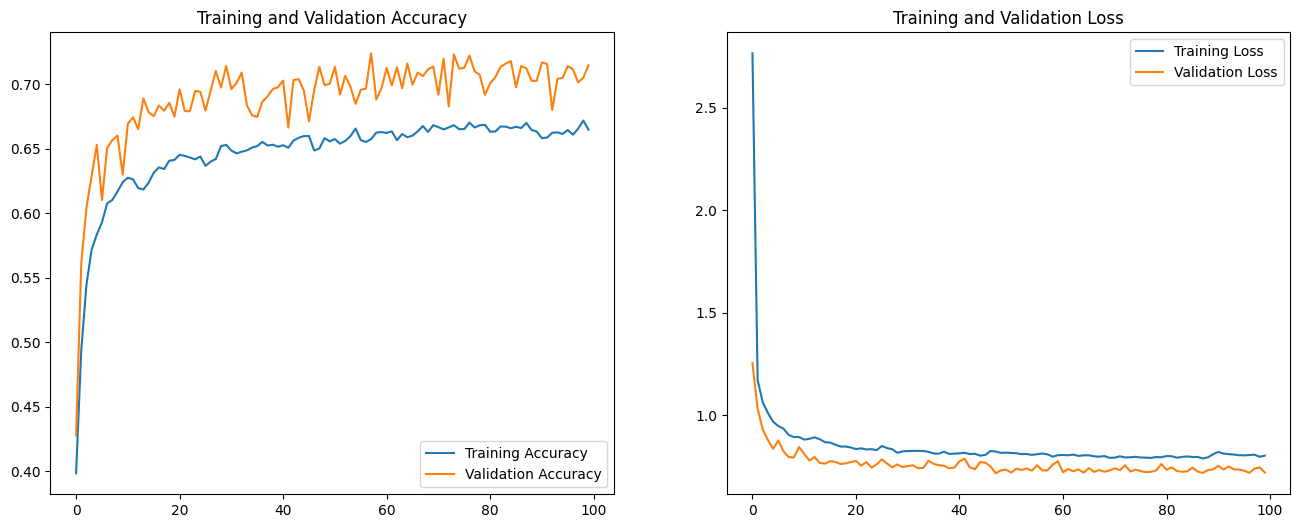

In [10]:
res_ycrcb_nonpre = train_model('content/img_YCrCb', preprocess=False)

In [11]:
pd.DataFrame(res_hls_pre).to_csv("densenet121_nontrainable/res_hls_pre.csv", index=False)
pd.DataFrame(res_hls_nonpre).to_csv("densenet121_nontrainable/res_hls_nonpre.csv", index=False)
pd.DataFrame(res_luv_pre).to_csv("densenet121_nontrainable/res_luv_pre.csv", index=False)
pd.DataFrame(res_luv_nonpre).to_csv("densenet121_nontrainable/res_luv_nonpre.csv", index=False)
pd.DataFrame(res_ycrcb_pre).to_csv("densenet121_nontrainable/res_ycrcb_pre.csv", index=False)
pd.DataFrame(res_ycrcb_nonpre).to_csv("densenet121_nontrainable/res_ycrcb_nonpre.csv", index=False)